In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re
from datetime import datetime
import unicodedata

In [2]:
datetime.now()

datetime.datetime(2020, 4, 12, 5, 6, 54, 382683)

In [3]:
url = 'https://www.health.gov.au/news/health-alerts/novel-coronavirus-2019-ncov-health-alert/coronavirus-covid-19-current-situation-and-case-numbers'
content = requests.get(url).content

In [4]:
soup = BeautifulSoup(content)
data = soup.findAll(text=re.compile('As .+')) + \
        soup.findAll(text=re.compile('.*(?:(Australian Capital Territory)|(Queensland)|(Victoria)|(New South Wales)|(South Australia)|(Western Australia)|(Northern Territory)|(Tasmania)|(Diamond Princess))')) 
data = ' '.join(data)
data

'\n        As at 6:00am on 12 April 2020, there have been 6,289 confirmed cases of COVID-19 in Australia. There have been 51 new cases since 6:00am yesterday.        Australian Capital Territory New South Wales Northern Territory Queensland South Australia Tasmania Victoria Western Australia \n                    ** The number of new cases in NSW increased by 7, but their total has been revised down by 10. On 11 April 2020, it was determined that 9 cases were interstate residents who are in their home jurisdiction and are yet to be confirmed by those jurisdictions, and 1 case was a false positive result.\r\nIncludes Diamond Princess repatriation cases: Qld (3), SA (1), Vic (4), WA (2, including 1 death)                  '

In [5]:
cases_str = unicodedata.normalize("NFKD", data)

In [6]:
cases_str

'\n        As at 6:00am on 12 April 2020, there have been 6,289 confirmed cases of COVID-19 in Australia. There have been 51 new cases since 6:00am yesterday.        Australian Capital Territory New South Wales Northern Territory Queensland South Australia Tasmania Victoria Western Australia \n                    ** The number of new cases in NSW increased by 7, but their total has been revised down by 10. On 11 April 2020, it was determined that 9 cases were interstate residents who are in their home jurisdiction and are yet to be confirmed by those jurisdictions, and 1 case was a false positive result.\r\nIncludes Diamond Princess repatriation cases: Qld (3), SA (1), Vic (4), WA (2, including 1 death)                  '

In [7]:
date_time_str = re.search('As .+ (\d+ \w+ 202\d)' ,cases_str).group(1)
date_time_str

'12 April 2020'

In [8]:
data_date_time = datetime.strptime(date_time_str, '%d %B %Y').strftime('%Y-%m-%d')
data_date_time

'2020-04-12'

In [9]:
# m = re.search('there were (\d+) confirmed cases', cases_str)
# australia = int(m.group(1))
# australia

In [10]:
# m = re.search('(\d+) in New South Wales', cases_str)
# nsw = int(m.group(1))


In [11]:
# m = re.search('(\d+) in Victoria', cases_str)
# victoria = int(m.group(1))

In [12]:
# m = re.search('(\d+) in South Australia', cases_str)
# sa = int(m.group(1))

In [13]:
# m = re.search('(\d+) in Queensland', cases_str)
# qld = int(m.group(1))

In [14]:
# m = re.search('(\d+) in Tasmania', cases_str)
# tas = int(m.group(1))


In [15]:
# m = re.search('(\d+) in .* Australian Capital Territory', cases_str)
# act = int(m.group(1))



In [16]:
# m = re.search('(\d+) in Northern Territory', cases_str)
# nt = int(m.group(1))


In [17]:
# m = re.search('(\d+) .* Diamond Princess', cases_str)
# wa = int(m.group(1))


### Dataframe

In [18]:
df1 = pd.read_html(url)[0]
df1 = df1.set_index('Location').T
df1

Location,Australian Capital Territory,New South Wales,Northern Territory,Queensland,South Australia,Tasmania,Victoria,Western Australia,Total**,"* Note that under National Notifiable Diseases Surveillance System reporting requirements, cases are reported based on their Australian jurisdiction of residence rather than where they were detected. For example, a case reported previously in the NT in a NSW resident is counted in the national figures as a NSW case. ** The number of new cases in NSW increased by 7, but their total has been revised down by 10. On 11 April 2020, it was determined that 9 cases were interstate residents who are in their home jurisdiction and are yet to be confirmed by those jurisdictions, and 1 case was a false positive result. Includes Diamond Princess repatriation cases: Qld (3), SA (1), Vic (4), WA (2, including 1 death)"
Confirmed cases*,103,2854,27,974,429,123,1265,514,6289,* Note that under National Notifiable Diseases...


In [19]:


df1.insert(0, 'date', data_date_time)
df = df1.rename(columns={
    'Total**':'australia',
    'Australian Capital Territory':'act',
    'New South Wales':'nsw',
    'Queensland':'qld',
    'South Australia':'sa',
    'Tasmania':'tas',
    'Victoria':'victoria',
    'Western Australia':'wa',
    'Northern Territory':'nt',
})
df

Location,date,act,nsw,nt,qld,sa,tas,victoria,wa,australia,"* Note that under National Notifiable Diseases Surveillance System reporting requirements, cases are reported based on their Australian jurisdiction of residence rather than where they were detected. For example, a case reported previously in the NT in a NSW resident is counted in the national figures as a NSW case. ** The number of new cases in NSW increased by 7, but their total has been revised down by 10. On 11 April 2020, it was determined that 9 cases were interstate residents who are in their home jurisdiction and are yet to be confirmed by those jurisdictions, and 1 case was a false positive result. Includes Diamond Princess repatriation cases: Qld (3), SA (1), Vic (4), WA (2, including 1 death)"
Confirmed cases*,2020-04-12,103,2854,27,974,429,123,1265,514,6289,* Note that under National Notifiable Diseases...


In [20]:
df.drop(columns=df.columns[-1], inplace=True)
df

Location,date,act,nsw,nt,qld,sa,tas,victoria,wa,australia
Confirmed cases*,2020-04-12,103,2854,27,974,429,123,1265,514,6289


In [21]:
assert int(df['australia'])>0

In [22]:
df

Location,date,act,nsw,nt,qld,sa,tas,victoria,wa,australia
Confirmed cases*,2020-04-12,103,2854,27,974,429,123,1265,514,6289


### Save to file

In [23]:
from pathlib import Path
csv_file = '../data/australia-cases.csv'

if Path(csv_file).exists():
    # read out the old data
    old_df = pd.read_csv(csv_file)
    df = df.append(old_df)
df.drop_duplicates(subset=['date'], inplace=True)

In [24]:
df.sort_values(by=['date'], inplace=True)
df.to_csv(csv_file, index=False)
df

Location,date,act,nsw,nt,qld,sa,tas,victoria,wa,australia
0,2020-02-04,NaN,4,NaN,2,2,NaN,4,NaN,12
1,2020-02-05,NaN,4,NaN,3,2,NaN,4,NaN,13
2,2020-02-06,NaN,4,NaN,4,2,NaN,4,NaN,14
3,2020-02-07,NaN,4,NaN,5,2,NaN,4,NaN,15
4,2020-02-08,NaN,4,NaN,5,2,NaN,4,NaN,15
...,...,...,...,...,...,...,...,...,...,...
63,2020-04-08,99,2734,27,943,420,97,1212,481,6013
64,2020-04-09,100,2773,27,953,421,106,1228,495,6103
65,2020-04-10,103,2822,27,965,428,111,1241,506,6203
66,2020-04-11,103,2857,27,974,429,123,1265,514,6292


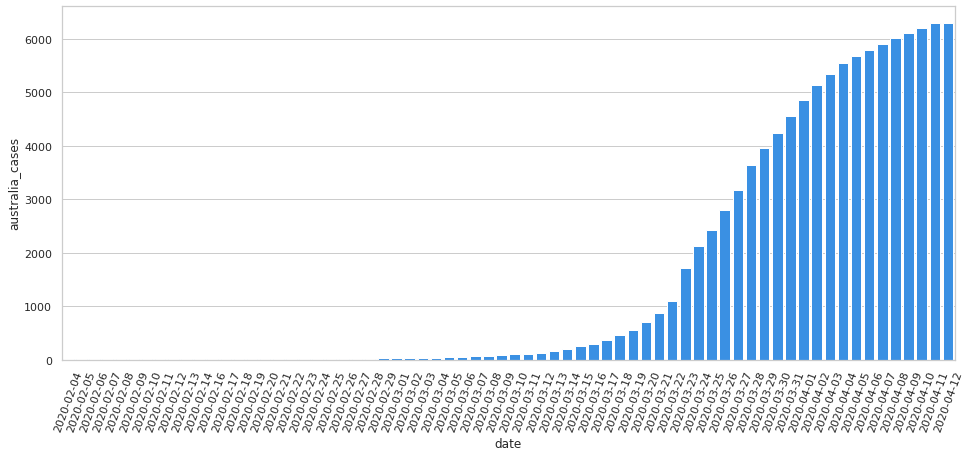

In [25]:
# plot
df['australia_cases']= df['australia'].apply(lambda x: int(x))

import seaborn as sns


sns.set(rc={'figure.figsize':(16,6.5)})
sns.set(style="whitegrid")


bar_chart = sns.barplot(x='date', y='australia_cases', color='dodgerblue', data=df)
bar_chart.tick_params(axis='x', labelrotation=70)


In [26]:
png_file = '../images/australia-cases.png'
bar_chart_fig = bar_chart.get_figure()
bar_chart_fig.savefig(png_file)
